# Import des modules

In [1]:
import nltk
import pandas as pd
import numpy as np
import wordcloud
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

# Chargement des données
![South Park](https://upload.wikimedia.org/wikipedia/en/4/41/South_Park_main_characters.png)

In [2]:
# Jeu de données récupéré sur kaggle : https://www.kaggle.com/tovarischsukhov/southparklines
df = pd.read_csv("southpark.csv")

# Explorons le dataset

----
Si vous ne connaissez pas pandas c'est le moment de prendre 10min pour vous former : https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

----
Cartman parle beaucoup il occupe la parole x% du temps : quel est cette proportion?

In [3]:
df.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [4]:
# Quels sont les personnages les plus présents ?
df["Character"].value_counts().head(10)

Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Mr. Mackey       633
Name: Character, dtype: int64

In [5]:
df.describe()

,Season,Episode,Character,Line
count,70896,70896,70896,70896
unique,19,19,3950,64301
top,2,10,Cartman,What?\n
freq,6416,5271,9774,361


# Cartman or Not Cartman

![South Park](https://cdn.radiofrance.fr/s3/cruiser-production/2019/09/31a9cba2-d57f-4172-9ff1-93a0fe505e75/801x410_eric_cartman_south_park.jpg)

On voit que Cartman est le personnage le plus présent dans le dataset, il prend la paole 14% du temps.

On va préparer le jeu de données pour résoudre le problème suivant :
Pour chaque phrase du jeu de donnée on veut vouloir prédire si elle a été prononcée par Cartman ou par quelqu'un d'autre

Pour commencer on va ajouter la colonne "is_cartman" au dataframe df : elle doit être à 1 si c'est cartman qui a prononcé la phrase, 0 si ce n'est pas lui

In [6]:
df["is_cartman"] = df["Character"].apply(lambda c: 1 if c == "Cartman" else 0)

In [7]:
df.sample(10)

,Season,Episode,Character,Line,is_cartman
29652,1,6,Stan,Really??\n,0
25128,17,9,Stan,We're done with betrayal! It's time to put an ...,0
67763,9,2,Man 1,"Yeah man, the corporations. Right now they're ...",0
26475,18,4,Nathan,I had a handicap way before you got paid to ha...,0
23762,17,3,Cartman,"That was, he was on my ground. You all saw tha...",1
62074,7,9,Stan,"Beside, maybe our sound would have gotten down...",0
20944,16,5,Stan,"Oh, hey.\n",0
51505,5,5,Phillip,"Well, what the hell? I already flew all the wa...",0
6894,11,14,Jenny,You just couldn't let it go! \n,0
64586,8,4,OC Member 2,"Well, what we got here?\n",0


On va équilibrer le problème, on veut conserver autant de is_cartman à 0 qu'à 1.

In [8]:
nb_cartman = len(df.query("is_cartman == 1"))
nb_cartman

9774

In [9]:
not_cartman = df.query("is_cartman == 0").sample(nb_cartman)

In [10]:
df = pd.concat([df.query("is_cartman == 1"), not_cartman])

In [11]:
df = df.sample(frac=1.0)

In [12]:
# Si ça passe ça doit être bon
assert len(df.query("is_cartman == 1")) == len(df.query("is_cartman == 0"))
assert len(df.query("is_cartman == 1")) == nb_cartman

Conservons uniquement les colonnes qui vont nous intéresser : Line et is_cartman

In [13]:
df = df[["Line", "is_cartman"]]

In [14]:
# Si ça passe ça doit être bon
assert (df.columns == ["Line", "is_cartman"]).all()

On va splitter aléatoirement le dataframe en 2, un dataframe pour l'entrainement du modèle et un autre pour la validation.

On veut 50% des données pour l'entrainement et 50% pour la validation et on les appelle df_train et df_valid

In [15]:
df_train, df_valid = sklearn.model_selection.train_test_split(df, test_size=0.5)

In [16]:
assert len(df_train) == len(df_valid), "train et valid n'ont pas la même taille"
assert len(df_train) == len(df) / 2, "df doit être 2x plus grand que train"

On va oublier un temps df_valid et se concentrer uniquement à la préparation des données sur df_train

# Text preprocessing

faites une fonction extract_tokens qui pour extraire les tokens d'un texte :
    - nltk est l'outil parfait pour vous aider (https://www.nltk.org/)
    - les textes sont en anglais, veuillez à bien utiliser les fonctions en english

In [17]:
text = "This is a sample text. Use it to test your function!"

In [18]:
# nécessaire la 1ere fois
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jacq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
def extract_tokens(text):
    res = []
    for sent in nltk.sent_tokenize(text):
        res += nltk.word_tokenize(sent)
    return res

In [20]:
# Si ça passe c'est bon
assert (extract_tokens(text) == ["This", "is", "a", "sample", "text", ".", "Use", "it", "to", "test", "your", "function", "!"]), "nope"

Nettoyez le texte en créant la fonction clean_tokens: supprimez la ponctuation et mettez tout en minuscule

In [21]:
import string

def clean_tokens(tokens):
    return [token.lower() for token in tokens if token not in string.punctuation]

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
# Si ça passe c'est bon
assert (clean_tokens(extract_tokens(text)) == ["this", "is", "a", "sample", "text", "use", "it", "to", "test", "your", "function"]), "nope"

Ajoutez la colonne tokens à votre dataframe d'entrainment

In [24]:
df_train["tokens"] = df_train["Line"].apply(lambda s: clean_tokens(extract_tokens(s)))

In [25]:
# Si ça passe ça doit être bon
assert (df_train.columns == ["Line", "is_cartman", "tokens"]).all()

# Visualisons les mots

On va générer des wordcloud représentant la fréquence des mots dans notre dataset

On va pour cela compter tous les mots puis les afficher avec le package wordcloud : http://amueller.github.io/word_cloud/

Comptons tous les mots et créons le dictionnaire word_freq = {"mot": nb_occurence_mot}

In [26]:
from collections import Counter
word_freq = df_train["tokens"].apply(Counter).sum()

In [27]:
word_freq.most_common(10)

[('you', 4371),
 ('i', 4062),
 ('the', 3486),
 ('to', 2791),
 ("'s", 2395),
 ('a', 2117),
 ('it', 2113),
 ('and', 1953),
 ('that', 1765),
 ('we', 1720)]

on peut utiliser maintenant utiliser : http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud.generate_from_frequencies

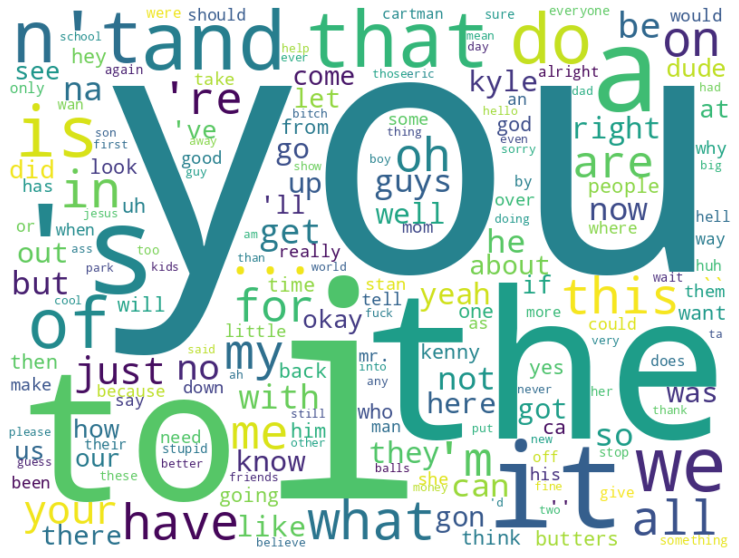

In [28]:
wc = wordcloud.WordCloud(
    width=800, height=600, 
    prefer_horizontal=1, background_color="white"
).generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Qu'est-ce que vous observez?
Qu'a t'on oublié?
Appliquez le correctif sur les données et affichez à nouveau les wordclouds

In [29]:
# Il manquait les stop words
from nltk.corpus import stopwords
GARBAGE = {"'s", "n't", '...', 'oh',"'m", "'re", "'", "''", "'ve", "'ll", "'d", "``" }
STOP_WORDS = set(stopwords.words('english')).union(GARBAGE)

def remove_stop_words(tokens):
    return [token for token in tokens if token not in STOP_WORDS]

df_train["tokens"] = df_train["tokens"].apply(remove_stop_words)

Reproduisez la même chose sur les sous ensembles is_cartman == 0 et is_cartman == 1

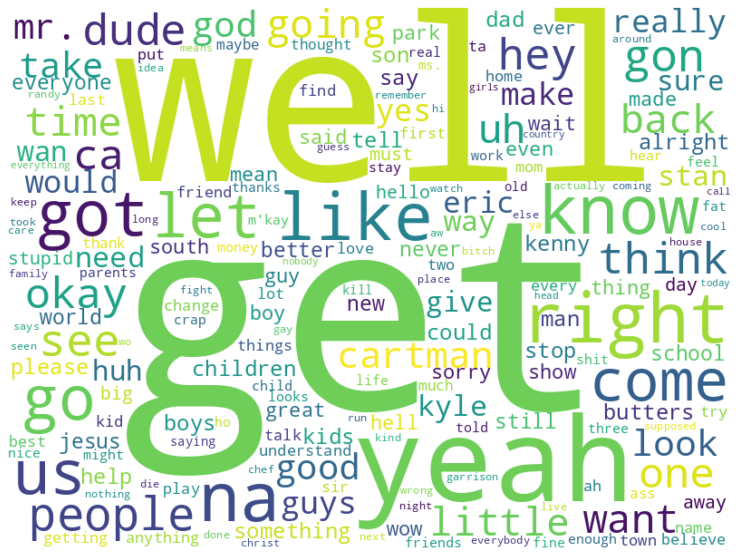

[('get', 271),
 ('well', 255),
 ('yeah', 255),
 ('right', 236),
 ('na', 229),
 ('know', 223),
 ('like', 212),
 ('got', 192),
 ('go', 186),
 ('let', 183)]

In [30]:
word_freq_other = df_train.query("is_cartman == 0")["tokens"].apply(Counter).sum()
wc = wordcloud.WordCloud(
    width=800, height=600, 
    prefer_horizontal=1, background_color="white"
).generate_from_frequencies(word_freq_other)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
word_freq_other.most_common(10)

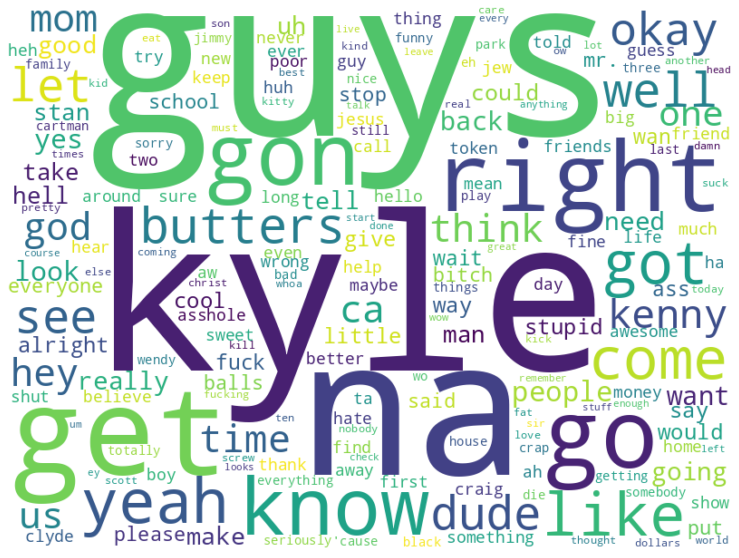

[('guys', 458),
 ('kyle', 426),
 ('na', 356),
 ('get', 349),
 ('right', 294),
 ('go', 292),
 ('gon', 277),
 ('know', 270),
 ('yeah', 268),
 ('like', 254)]

In [31]:
word_freq_cartman = df_train.query("is_cartman == 1")["tokens"].apply(Counter).sum()
wc = wordcloud.WordCloud(
    width=800, height=600, 
    prefer_horizontal=1, background_color="white"
).generate_from_frequencies(word_freq_cartman)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
word_freq_cartman.most_common(10)

# Bag of words

Le texte est maintenant nettoyé, on va le transformer en features en prenant le modèle basique du "bag of words".

Vous allez construire tout d'abord le dictionnaire complet des mots du corpus, et associer à chaque mot un id entre 0 et nb_words.
Cet id correspondra à la position du mot dans le vecteur des features

In [32]:
words_to_id = dict()
for _, tokens in df_train["tokens"].iteritems():
    for word in set(tokens):
        if word not in words_to_id:
            words_to_id[word] = len(words_to_id)

Pour chaque réplique vous allez compter le nombre d'occurences de chaque mot et générer le vecteur des features en utilisant le dictionnaire que vous venez de générer

In [33]:
def bag_of_words_to_vector(bag_of_words, words_to_id):
    vec = np.zeros(len(words_to_id))
    counts = Counter(bag_of_words)
    for word, count in counts.items():
        if word in words_to_id:
            vec[words_to_id[word]] = count
    return vec

Générez la matrice X_train qui pour chaque ligne contient les features.

Ca doit être un np.array de taille (len(df_train), len(words_to_id))

In [34]:
def generate_features(df, words_to_id):
    features = []
    for _, row in df.iterrows():
        features.append(bag_of_words_to_vector(row["tokens"], words_to_id))
    return np.array(features)

In [35]:
X_train = generate_features(df_train, words_to_id)

In [36]:
assert type(X_train) == np.ndarray, "X_train doit être un np.array"
assert X_train.shape == (len(df_train), len(words_to_id)), "Mauvaise taille"

In [37]:
# On prépare le vecteur à prédire
y_train = df_train["is_cartman"]

# Un peu de Machine learning

On va maintenant utiliser scikit learn pour apprendre une régression logistique sur nos données d'entrainement : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Etape 1 : Créez le modèle

Etape 2 : fit(X, y)

Etape 3 : Evaluons les performances

Commencez par instancier le modèle et lancez l'apprentissage sur l'ensemble de train

In [38]:
ml = sklearn.linear_model.LogisticRegression()
ml.fit(X_train, y_train)

LogisticRegression()

In [39]:
predictions = ml.predict(X_train) 
{
    "nombre_succes":  len(y_train) - abs(predictions - y_train).sum(), 
    "nombre_erreurs": abs(predictions - y_train).sum(), 
    "nombre_predictions" : len(y_train), 
    "taux_erreur" : abs(predictions - y_train).sum() / len(y_train),
    "taux_succes": 1- abs(predictions - y_train).sum() / len(y_train)
}

{'nombre_succes': 8269,
 'nombre_erreurs': 1505,
 'nombre_predictions': 9774,
 'taux_erreur': 0.15397994679762636,
 'taux_succes': 0.8460200532023736}

Calculez la matrice de confusion : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [40]:
# Matrice de confusion
sklearn.metrics.confusion_matrix(y_train, predictions)

array([[4362,  534],
       [ 971, 3907]])

/home/jacq/anaconda/envs/tp3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jacq/anaconda/envs/tp3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


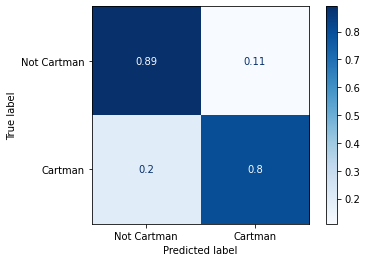

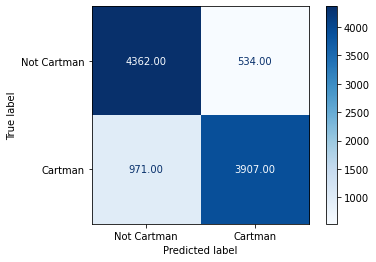

In [41]:
# Pretty print
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(ml, X_train, y_train,
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      normalize='true');
plot_confusion_matrix(ml, X_train, y_train, 
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      values_format=".2f");

Tracez la courbe roc : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html 

In [42]:
fpr_lr_train, tpr_lr_train, thresholds_train = sklearn.metrics.roc_curve(y_train, ml.predict_proba(X_train)[:, 1])

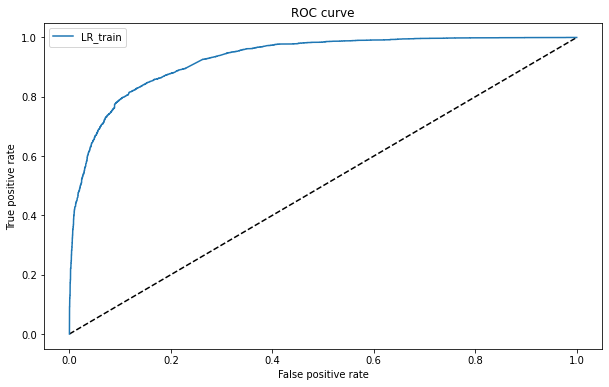

In [43]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_train, tpr_lr_train, label='LR_train')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

# Pas si vite!
On a appris sur ces données. 
On n'est pas en train d'évaluer les prédictions, on observe juste à quel point l'algorithme a réussi à fitter sur les données d'apprentissage.

In [44]:
df_valid["tokens"] = df_valid["Line"].apply(lambda s: remove_stop_words(clean_tokens(extract_tokens(s))))

In [45]:
X_valid = generate_features(df_valid, words_to_id)
y_valid = df_valid["is_cartman"]

In [46]:
y_predict = ml.predict(X_valid) 
{
    "nombre_succes":  len(y_valid) - abs(y_predict - y_valid).sum(), 
    "nombre_erreurs": abs(y_predict - y_valid).sum(), 
    "nombre_predictions" : len(y_valid), 
    "taux_erreur" : abs(y_predict - y_valid).sum() / len(y_valid),
    "taux_succes": 1- abs(y_predict - y_valid).sum() / len(y_valid)
}

{'nombre_succes': 6448,
 'nombre_erreurs': 3326,
 'nombre_predictions': 9774,
 'taux_erreur': 0.3402905668099038,
 'taux_succes': 0.6597094331900961}

Calculez la matrice de confusion : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[[3517 1361]
 [1965 2931]]


/home/jacq/anaconda/envs/tp3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jacq/anaconda/envs/tp3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jacq/anaconda/envs/tp3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be rem

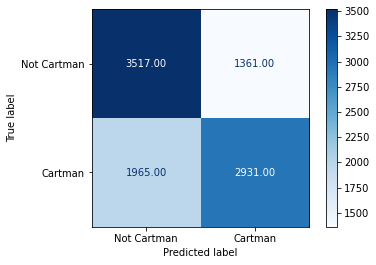

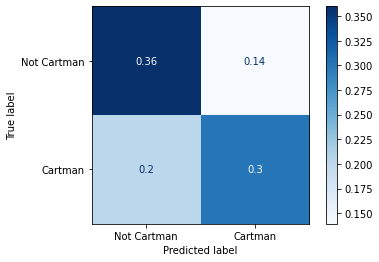

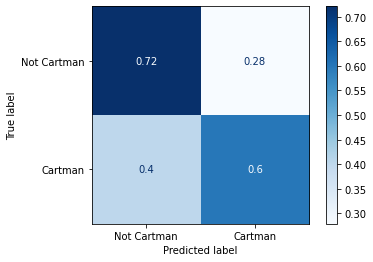

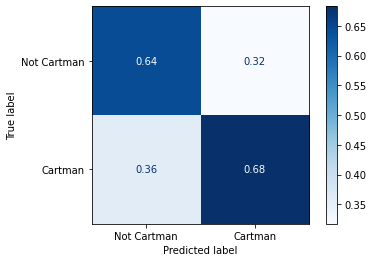

In [47]:
print(sklearn.metrics.confusion_matrix(y_valid, y_predict))
plot_confusion_matrix(ml, X_valid, y_valid, 
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      values_format=".2f");
plot_confusion_matrix(ml, X_valid, y_valid, 
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      normalize='all'
                     );
plot_confusion_matrix(ml, X_valid, y_valid,
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      normalize='true');
plot_confusion_matrix(ml, X_valid, y_valid,
                      display_labels=["Not Cartman", "Cartman"],
                      cmap=plt.cm.Blues, 
                      normalize='pred');

Tracez la courbe roc : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html 

In [48]:
fpr_lr_valid, tpr_lr_valid, threshold_valid = sklearn.metrics.roc_curve(y_valid, ml.predict_proba(X_valid)[:, 1])

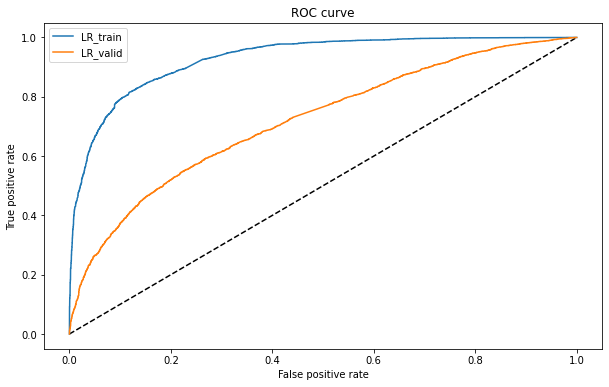

In [49]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_train, tpr_lr_train, label='LR_train')
plt.plot(fpr_lr_valid, tpr_lr_valid, label='LR_valid')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

In [50]:
# Aire sous la courbe ROC - train
sklearn.metrics.roc_auc_score(y_train, ml.predict_proba(X_train)[:, 1])

0.928906411204635

In [51]:
# Aire sous la courbe ROC - valid
sklearn.metrics.roc_auc_score(y_valid, ml.predict_proba(X_valid)[:, 1])

0.7196986578730166

# Conclusion

Dans ce TP on a procédé en 3 étapes pour résoudre notre problème: 

### 1. Pre-processing :
 
     - Modèle Bag of Words
     - Extraction de tokens
     - Filtrage des stop words
     - Conversion des bag of tokens en vecteurs
     
### 2. Machine Learning :
 
     - Préparation des données d'entrainement et de validation : Split + preprocessing identique
     - Choix d'un modèle adapté au problème : Régression logistique
     - Entrainement : fit(X, y)
     
### 3. Evaluation et analyse des résultats :
    
    - On n'évalue pas les performances d'un modèle sur les données d'entrainement ! 
    - Métriques à suivre pour un classifier binaire : matrice de confusion, Courbe ROC, Aire sous la courbe ROC

# Quelles sont les pistes d'amélioration ?

Si l'on n'est pas satisfait des performances de notre modèle on a 3 axes d'améliorations possible:

    1. Améliorer le préprocessing
    2. Améliorer le modèle de machine learning
    3. Changer de paradigme

## Améliorations du préprocessing

3 pistes évoquées en cours :

 - Utilisation d'un stemmer ou lemmatizer :  https://kite.com/python/docs/nltk.SnowballStemmer
 - Dans le TP on a juste utilisé la fréquence des mots : On a évoqué le tf-idf en cours https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

 - Le modèle Bag of Words nous fait perdre l'ordre des mots : Les n-grams à la rescousse

On peut aussi ajouter d'autres features :
 - Utilisation de la ponctuation : est-ce que des personnages utilisent plus "!" ou "?" ?
 - On a converti tout le texte en minuscule : est-ce que le rapport des lettres en majuscule sur les lettres en minuscule ajoute de l'information?

## Améliorations du modèle de machine learning

On a utilisé un classifier linéaire, la régression logistique.

Il en existe bien d'autres : https://scikit-learn.org/stable/supervised_learning.html#supervised-learning (implémentés dans sklearn)

Ces modèles ont en plus beaucoup d'hyperparamètres qui peuvent être spécifiés. Il faut alors ajouter une boucle pour identifier les meilleurs paramètres sur notre jeux de données : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

On peut aussi se rendre compte que toutes les features ne sont pas intéressantes à utiliser. Certaines apportent plus de bruit que de gain. On peut ajouter à notre modèle une étape de sélection des features à conserver : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection

# Changer de paradigme

## Cours n°2 : Donner du sens au NLP